# Creating a fully connected neural network

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import subprocess
from termcolor import colored

In [2]:
# Selection of a GPU
gpu_num = -1

#Loop through avtive GPUs to check for free GPUs
for i in range(7, 0, -1):
    print(i)
    result = subprocess.run(f"nvidia-smi -i {i}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if "No running processes found" in result.stdout:
        gpu_num = i
        break

#If no GPU found, only run nvidia-smi once
first_attempt = True

#Ensure correct input
while 0 > gpu_num or gpu_num > 7:
    #Run nvidia-smi command
    if first_attempt:
        !nvidia-smi
        first_attempt = False

    #Type checking for int between 0 and 7
    try:
        gpu_num = int(input("No Free GPUs Found, manually enter GPU index (0-7): "))
        if 0 <= gpu_num <= 7:
            break
        else:
            print("Error: GPU index must be between 0 and 7.")
    except ValueError:
        print("Error: Please enter a valid integer.")

#Declare device as free device found above  
device = torch.device(f'cuda:{gpu_num}' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

7
6
Using device: cuda:6


In [3]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.input_size = input_size

        # Separate fully connected layers for each feature set
        self.fc1_1 = nn.Linear(input_size, input_size // 2)
        self.fc1_2 = nn.Linear(input_size, input_size // 2)
        self.fc1_3 = nn.Linear(input_size, input_size // 2)

        # Trainable weights for weighted summation
        self.weight1 = nn.Parameter(torch.tensor(1.0))
        self.weight2 = nn.Parameter(torch.tensor(1.0))
        self.weight3 = nn.Parameter(torch.tensor(1.0))

        # Combined fully connected layers
        self.fc2 = nn.Linear((input_size // 2), input_size // 4)
        self.fc3 = nn.Linear(input_size // 4, output_size)
        self.relu = nn.ReLU()

    def forward(self, x1, x2, x3):
        # Apply separate fully connected layers to each feature set
        x1 = self.fc1_1(x1)
        x2 = self.fc1_2(x2)
        x3 = self.fc1_3(x3)

        # Weighted summation of feature sets
        x = self.weight1 * x1 + self.weight2 * x2 + self.weight3 * x3

        # Pass through additional fully connected layers
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs, patience):
    time_start = time()
    model.train()
    epoch_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    final_epoch = -1
    
    for epoch in range(epochs):
        total_loss = 0
        for features1, features2, features3, labels in train_loader:
            labels = labels.type(torch.LongTensor).to(device)
            features1, features2, features3 = features1.to(device), features2.to(device), features3.to(device)

            # Forward pass
            outputs = model(features1, features2, features3)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            optimizer.zero_grad()           # reset gradient
            loss.backward()                 # automated backwards pass
            optimizer.step()                # take a step

            total_loss += loss.item()
            
        avg_loss = total_loss / len(train_loader)
        epoch_losses.append(avg_loss)  # Store the average loss

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features1, features2, features3, labels in val_loader:
                labels = labels.type(torch.LongTensor).to(device)
                features1, features2, features3 = features1.to(device), features2.to(device), features3.to(device)
                outputs = model(features1, features2, features3)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')
        final_epoch = epoch+2

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(colored(f'Early stopping triggered after {epoch+1} epochs.', 'red'))
                break

    # Load the best model state
    model.load_state_dict(best_model_state)

    time_stop = time()
    time_elapsed = time_stop - time_start
    print(f'Elapsed time {round(time_elapsed, 1)} sec.')

    # Plotting the loss over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, final_epoch), epoch_losses, marker='o')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.xticks(range(1, epochs + 1))
    plt.grid()
    plt.show()

    # Plotting the validation error over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, final_epoch), val_losses, marker='o')
    plt.title('Validation Error over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Error')
    plt.xticks(range(1, epochs + 1))
    plt.grid()
    plt.show()

In [5]:
# Testing loop with confusion matrix
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images1, images2, images3, labels in test_loader:
            images1, images2, images3, labels = images1.to(device), images2.to(device), images3.to(device), labels.to(device)
            outputs = model(images1, images2, images3)
            _, predicted = torch.max(outputs.data, 1)  # predicted = index of maximum probability
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Append true and predicted labels for confusion matrix
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate and print accuracy
    accuracy = 100 * correct / total
    print(f'Test Accuracy of the model on the test dataset: {accuracy:.2f}%')

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [6]:
def runModel(file_name, batch_size=512, epochs=25, lrate=0.01, patience=16):
    # Load three separate feature sets
    data1 = np.load(f"Features/{file_name}_Normal.npz")
    features1 = data1['features']
    print('data1 loaded')
    data2 = np.load(f"Features/{file_name}_Fourier.npz")
    features2 = data2['features']
    print('data2 loaded')
    data3 = np.load(f"Features/{file_name}_HighPass.npz")
    features3 = data3['features']
    print('data3 loaded')
    labels = data1['labels']
    print('labels loaded')

    print(features1.shape)
    print(features2.shape)
    print(features3.shape)
    print(labels.shape)

    
    _, test_indices = train_test_split(
        range(len(labels)), test_size=0.2, random_state=0, stratify=labels
    )
    mask = np.ones(len(labels), dtype=bool)
    mask[test_indices] = False
    train_indices = np.arange(len(labels))[mask]
    X1_train, X1_test = features1[train_indices], features1[test_indices]
    X2_train, X2_test = features2[train_indices], features2[test_indices]
    X3_train, X3_test = features3[train_indices], features3[test_indices]
    y_train, y_test = labels[train_indices], labels[test_indices]

    _, val_indices = train_test_split(
        range(len(y_train)), test_size=0.25, random_state=0, stratify=y_train
    )
    mask = np.ones(len(y_train), dtype=bool)
    mask[val_indices] = False
    train_indices = np.arange(len(y_train))[mask]
    X1_train, X1_val = features1[train_indices], features1[val_indices]
    X2_train, X2_val = features2[train_indices], features2[val_indices]
    X3_train, X3_val = features3[train_indices], features3[val_indices]
    y_train, y_val = labels[train_indices], labels[val_indices]

    # Convert to PyTorch tensors
    X1_train_tensor = torch.tensor(X1_train, dtype=torch.float32)
    X2_train_tensor = torch.tensor(X2_train, dtype=torch.float32)
    X3_train_tensor = torch.tensor(X3_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    X1_val_tensor = torch.tensor(X1_val, dtype=torch.float32)
    X2_val_tensor = torch.tensor(X2_val, dtype=torch.float32)
    X3_val_tensor = torch.tensor(X3_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    X1_test_tensor = torch.tensor(X1_test, dtype=torch.float32)
    X2_test_tensor = torch.tensor(X2_test, dtype=torch.float32)
    X3_test_tensor = torch.tensor(X3_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create PyTorch Datasets and DataLoaders
    train_dataset = TensorDataset(X1_train_tensor, X2_train_tensor, X3_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X1_val_tensor, X2_val_tensor, X3_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X1_test_tensor, X2_test_tensor, X3_test_tensor, y_test_tensor)

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    # Set up model, loss, and optimizer
    input_size = X1_train.shape[1]  # assuming all three have the same shape
    num_classes = len(np.unique(labels))
    model = NeuralNet(input_size=input_size, output_size=num_classes).to(device)
    
    print(colored("Neural Net Definition:", "blue"))
    print(f"{model}\n")
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lrate)

    # Train and test the model
    print(colored("Begin Model Training:", "blue"))
    train_model(model, train_loader, val_loader, criterion, optimizer, epochs=epochs, patience=patience)
    test_model(model, test_loader)

data1 loaded
data2 loaded
data3 loaded
labels loaded
(185015, 2048)
(185015, 2048)
(185015, 2048)
(185015,)
Neural Net Definition:
NeuralNet(
  (fc1_1): Linear(in_features=2048, out_features=1024, bias=True)
  (fc1_2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc1_3): Linear(in_features=2048, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=20, bias=True)
  (relu): ReLU()
)

Begin Model Training:
Epoch [1/50], Loss: 1.0917
Epoch [2/50], Loss: 0.2989
Epoch [3/50], Loss: 0.1903
Epoch [4/50], Loss: 0.1369
Epoch [5/50], Loss: 0.1052
Epoch [6/50], Loss: 0.0855
Epoch [7/50], Loss: 0.0720
Epoch [8/50], Loss: 0.0688
Epoch [9/50], Loss: 0.0587
Epoch [10/50], Loss: 0.0509
Epoch [11/50], Loss: 0.0409
Epoch [12/50], Loss: 0.0331
Epoch [13/50], Loss: 0.0419
Epoch [14/50], Loss: 0.0523
Epoch [15/50], Loss: 0.0416
Epoch [16/50], Loss: 0.0202
Epoch [17/50], Loss: 0.0240
Epoch [18/50], Loss: 0.0241

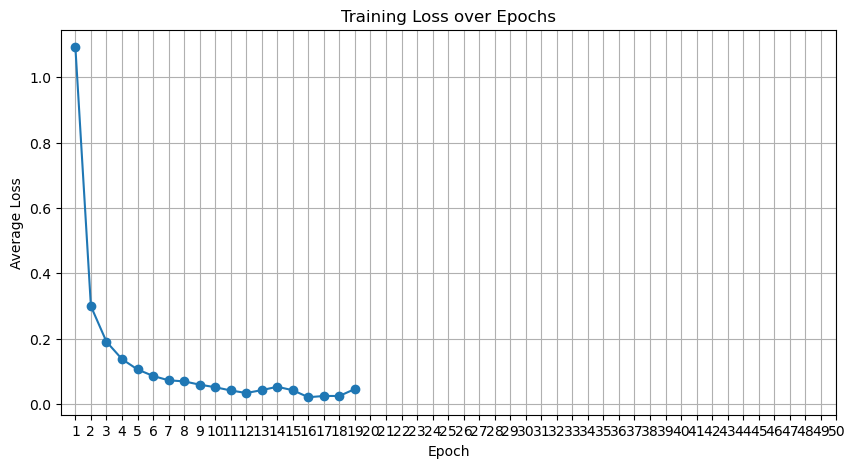

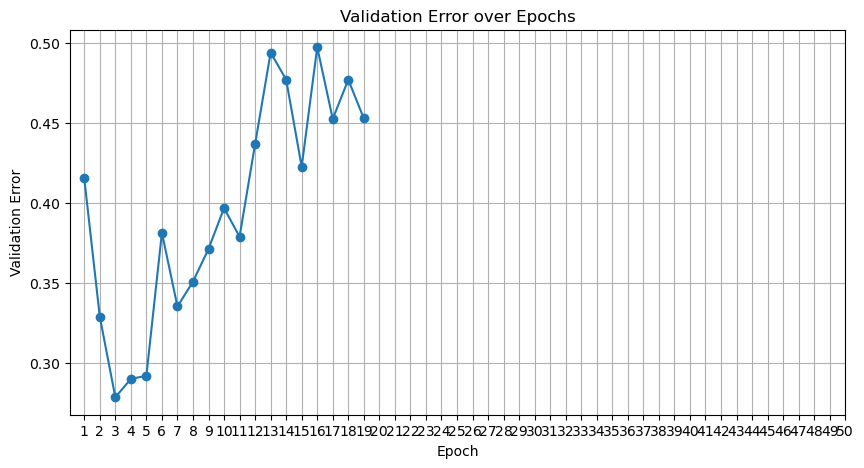

Test Accuracy of the model on the test dataset: 78.11%


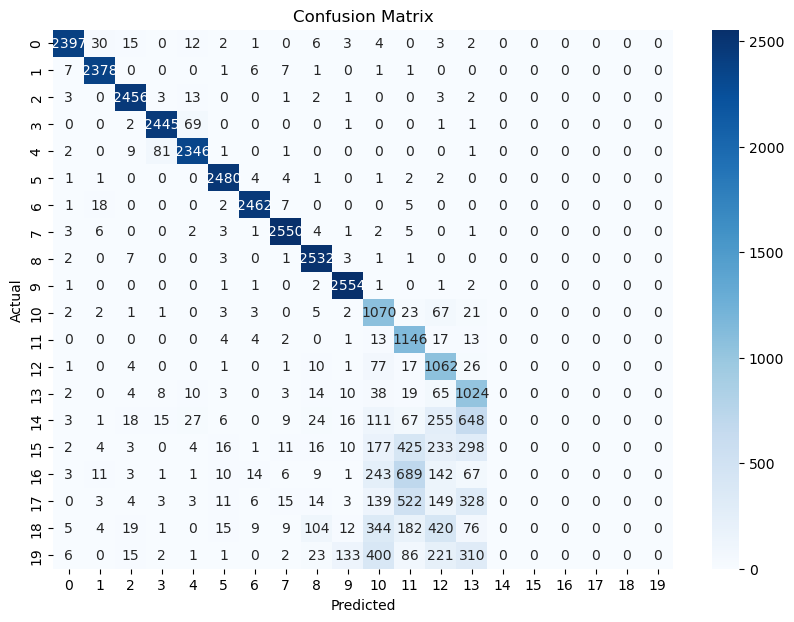

In [7]:
runModel(file_name='256_AI_And_Classes_features_VGG', batch_size=512, epochs=50, lrate=0.001, patience=16)